In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.autograd.functional import hessian
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm 
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import os
import copy
from torch.nn.utils import _stateless
import pandas as pd

In [3]:
def get_exp_details(root_dir, path):
    result_details={}
    details_path = root_dir+ 'details_'+ path + '.txt'
    with open(details_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        key, val = line[:-1].split(':')
        key, val = key.strip(' '), val.strip(' ')
        if key in ['ratio', 'alpha_0']:
            val = float(val)
        if key in ['Times', 'Weights', 'Epochs', 'book_keep_freq', 'g_times', 'g_epochs','g_weight', 'freq_reduce_by', 'freq_reduce_after']:
            val = int(val)
        result_details[key] = val
    return result_details

def get_exp_results(r_det):
    root_dir = r_det['result_root_dir']
    path = r_det['result_path']
    grad_file_path = root_dir+'grad_'+path
    hess_file_path = root_dir+'hess_'+path
    gen_file_path  = root_dir+'gen_'+path
    
    # print(result_details)
    grad_list    = []
    hess_list    = []
    gen_err_list = []
    
    with open(grad_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(') ')
        # print('tensors',tensors)
        t_list = [float(t[7:].split(' ')[0][:-1]) for t in tensors]
        # print('grad_list_i length:',len(t_list))
        grad_list.append(t_list)
    
    with open(hess_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(' ')
        # print('tensors',tensors)
        t_list = [float(t[7:-1]) for t in tensors]
        # print('hess_list_i length:',len(t_list))
        hess_list.append(t_list)
    
    with open(gen_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(' ')
        # print('tensors',tensors)
        t_list = [float(t) for t in tensors]
        # print('hess_list_i length:',len(t_list))
        gen_err_list.append(t_list)
        
    hess_list = np.array(hess_list)
    grad_list = np.array(grad_list)
    gen_err_list = np.array(gen_err_list)
    print('hess list shape:',hess_list.shape)
    print('grad list shape:',grad_list.shape)
    print('gen err list shape:',gen_err_list.shape)
    
    # K_g = np.max(np.mean(np.array(grad_list), 0))
    # L_g = np.max(np.mean(np.array(hess_list), 0))
    
    K_g = np.max(np.max(np.array(grad_list), 1))
    L_g = np.max(np.max(np.array(hess_list), 1))
    
    K_g_avg = np.mean(grad_list)
    L_g_avg = np.mean(hess_list)
    K_g_run_avg = []
    L_g_run_avg = []
    for i, kgi in enumerate(np.mean(grad_list, 0)):
        temp = np.mean(np.mean(grad_list, 0)[:i+1])
        K_g_run_avg.append(temp)
    for i,lgi in enumerate(np.mean(hess_list, 0)):
        temp = np.mean(np.mean(hess_list, 0)[:i+1])
        L_g_run_avg.append(temp)
        
    book_keep_freq = r_det['book_keep_freq']
    freq_reduce_after = r_det['freq_reduce_after']
    freq_reduce_by = r_det['freq_reduce_by']
    x_values = []
    count_keep = 0
    for i in range(20000):
        if i%book_keep_freq==0:
            x_values.append(i+1)
            count_keep+=1
            if count_keep%freq_reduce_after==0:
                book_keep_freq+=freq_reduce_by
    
    return grad_list, hess_list, K_g, L_g, x_values, gen_err_list, K_g_run_avg, L_g_run_avg, K_g_avg, L_g_avg

### Old function for plot

In [3]:
def get_running_upper_bound(l, x_values=None):
    ub = [l[0]]
    ub_x = [0]
    if x_values is not None:
        ub_x = [x_values[0]]
    else:
        x_values = range(len(l))
    for l_i, x_v in zip(l[1:], x_values[1:]):
        if ub[-1]<l_i:
            ub.append(l_i)
            ub_x.append(x_v)
    ub_x.append(x_values[-1])
    ub.append(max(l[-1], ub[-1]))
    return {'x': ub_x, 'y': np.array(ub)}

def get_avg_and_dev(l):
    running_avg = np.zeros_like(l)
    running_dev = np.zeros_like(l)
    for i in range(len(l)):
        running_avg[i] = np.mean(l[:i+1])
        running_dev[i] = np.std(l[:i+1])
    return running_avg, running_dev
    
def plot_e1(grad_list, hess_list, x_values=None, path=None, lp_ylim = None, sm_ylim = None):
    fig, ax =plt.subplots(figsize=(12,10))
    fontsize = 24
    ticksize = 20
    line_width = 3
    marker_size = 12
    rotation = -30
    if x_values is None:
        x_values = range(len(grad_list[0]))
    sns.set_style("whitegrid")
    
    grad_list_max = np.max(grad_list,0) ## max for every experiment per epochs
    grad_list_mean = np.mean(grad_list,0) ## mean for every experiment per epochs
    running_avg, running_dev =  get_avg_and_dev(grad_list_max)
    running_dev = np.std(grad_list, 0)
    
    print(running_avg[:10])
    print(running_dev[:10])
    print(grad_list_max[:10])
    
    # plt.plot(x_values, running_avg, 'orange', label='Running Average')
    # ax.fill_between(x_values, running_avg-running_dev, running_avg+ running_dev, color='orange', alpha=.2)
    ub_list = get_running_upper_bound(grad_list_max, x_values)
    plt.plot(ub_list['x'],ub_list['y'] , 'red',label='Empirical Max')
    
    # Old swigly plot
    # plt.plot(x_values, np.mean(grad_list,0), 'orange', label='Actual values')
    
    plt.ylabel('Parameter Lipschitz', fontsize=fontsize)
    plt.xlabel('Number of Datapoints', fontsize=fontsize)
    # plt.title('Mnist dataset', fontsize=fontsize)
    plt.xlim(-100, plt.xlim()[1])
    if lp_ylim is not None:
        plt.ylim(lp_ylim)
    ax.legend()
    sns.set(font='sans-serif', style='whitegrid', font_scale=2, rc={"lines.linewidth": line_width, "lines.markersize":marker_size})
    plt.xticks(rotation=rotation)
    if path is not None:
        plt.savefig('e1_Lp_const_'+ path)
    else:
        plt.show()
    
    fig, ax =plt.subplots(figsize=(12,10))
    sns.set_style("whitegrid")
    hess_list_max = np.max(hess_list,0) ## max for every experiment per epochs
    hess_list_mean = np.mean(hess_list,0) ## mean for every experiment per epochs
    running_avg, running_dev =  get_avg_and_dev(hess_list_max)
    running_dev = np.std(hess_list, 0)
    # plt.plot(x_values, running_avg, 'green', label='Running Average')
    # ax.fill_between(x_values, running_avg-running_dev, running_avg+ running_dev, color='green', alpha=.2)
    ub_list = get_running_upper_bound(hess_list_max, x_values)
    plt.plot(ub_list['x'],ub_list['y'] , 'red', label='Empirical Max')
    
    # old sqigly lines
    # plt.plot(x_values, hess_list_max,'green', label='Actual values')
    
    plt.ylabel('Parameter Smoothness', fontsize=fontsize)
    plt.xlabel('Number of Datapoints', fontsize=fontsize)
    plt.xlim(-100, plt.xlim()[1])
    if sm_ylim is not None:
        plt.ylim(sm_ylim)
    ax.legend()
    sns.set(font='sans-serif', style='whitegrid', font_scale=2, rc={"lines.linewidth": line_width, "lines.markersize":marker_size})
    # plt.title('Mnist dataset', fontsize=fontsize)
    plt.xticks(rotation=rotation)
    if path is not None:
        plt.savefig('e1_sm_const_'+path)
    else:
        plt.show()

### Function in use and old code for Plot used in ICLR submission

In [5]:
def get_running_upper_bound(l, x_values=None):
    ub = [l[0]]
    ub_x = [0]
    if x_values is not None:
        ub_x = [x_values[0]]
    else:
        x_values = range(len(l))
    for l_i, x_v in zip(l[1:], x_values[1:]):
        if ub[-1]<l_i:
            ub.append(l_i)
            ub_x.append(x_v)
    ub_x.append(x_values[-1])
    ub.append(max(l[-1], ub[-1]))
    return {'x': ub_x, 'y': np.array(ub)}

def get_avg_and_dev(l):
    running_avg = np.zeros_like(l)
    running_dev = np.zeros_like(l)
    for i in range(len(l)):
        running_avg[i] = np.mean(l[:i+1])
        running_dev[i] = np.std(l[:i+1])
    return running_avg, running_dev

### Commented the plot code for ICLR, now using new code for TMLR
# def plot_e1(grad_list, hess_list, x_values=None, path=None, lp_ylim = None, sm_ylim = None):
#     fig, ax =plt.subplots(figsize=(12,10))
#     fontsize = 40
#     keysize = 35
#     ticksize = 35
#     line_width = 6
#     marker_size = 12
#     rotation = -30
#     if x_values is None:
#         x_values = range(len(grad_list[0]))
#     sns.set_style("whitegrid")
    
#     grad_list_max = np.max(grad_list,0) ## max for every experiment per epochs
#     grad_list_mean = np.mean(grad_list,0) ## mean for every experiment per epochs
#     running_avg, running_dev =  get_avg_and_dev(grad_list_max)
#     running_dev = np.std(grad_list, 0)
    
#     # print(running_avg[:10])
#     # print(running_dev[:10])
#     # print(grad_list_max[:10])
    
#     # plt.plot(x_values, running_avg, 'orange', label='Running Average')
#     # ax.fill_between(x_values, running_avg-running_dev, running_avg+ running_dev, color='orange', alpha=.2)
#     ub_list = get_running_upper_bound(grad_list_max, x_values)
#     plt.plot(ub_list['x'],ub_list['y'] , 'orange',label='Parameter Lipschitz')
    
#     # Old swigly plot
#     # plt.plot(x_values, np.mean(grad_list,0), 'orange', label='Actual values')
#     # plt.yscale('log')
#     plt.ylabel('Empirical Max', fontsize=fontsize)
#     plt.xlabel('Number of Datapoints', fontsize=fontsize)
#     # plt.title('Mnist dataset', fontsize=fontsize)
#     plt.xlim(-100, plt.xlim()[1])
#     # if lp_ylim is not None:
#         # plt.ylim(lp_ylim)
#     # ax.legend()
#     sns.set(font='sans-serif', style='whitegrid', font_scale=2, rc={"lines.linewidth": line_width, "lines.markersize":marker_size})
    
#     # if path is not None:
#     #     plt.savefig('e1_Lp_const_'+ path)
#     # else:
#     #     plt.show()
    
#     # fig, ax =plt.subplots(figsize=(12,10))
#     # fig.add_subplots(label=2)
#     # sns.set_style("whitegrid")
#     hess_list_max = np.max(hess_list,0) ## max for every experiment per epochs
#     hess_list_mean = np.mean(hess_list,0) ## mean for every experiment per epochs
#     running_avg, running_dev =  get_avg_and_dev(hess_list_max)
#     running_dev = np.std(hess_list, 0)
#     # plt.plot(x_values, running_avg, 'green', label='Running Average')
#     # ax.fill_between(x_values, running_avg-running_dev, running_avg+ running_dev, color='green', alpha=.2)
#     ub_list = get_running_upper_bound(hess_list_max, x_values)
#     plt.plot(ub_list['x'],ub_list['y'] , 'green', label='Parameter smoothness')
    
#     # old sqigly lines
#     # plt.plot(x_values, hess_list_max,'green', label='Actual values')
#     # secax = ax.secondary_yaxis('right', functions=(np.deg2rad,np.rad2deg))
#     # secax.set_ylabel('Parameter Smoothness', fontsize=fontsize)
#     # plt.xlabel('Number of Datapoints', fontsize=fontsize)
#     # plt.xlim(-100, plt.xlim()[1])
#     if sm_ylim is not None:
#         plt.ylim(sm_ylim)
#     ax.legend(fontsize= keysize)
#     sns.set(font='sans-serif', style='whitegrid', font_scale=2, rc={"lines.linewidth": line_width, "lines.markersize":marker_size})
#     # plt.title('Mnist dataset', fontsize=fontsize)
#     plt.xticks(rotation=rotation, size=ticksize)
#     plt.yticks(size=ticksize)
#     plt.tight_layout()
#     if path is not None:
#         plt.savefig('e1_'+path, pad_inches=0)
#     else:
#         plt.show()

## Better plots

In [6]:
def plot_stability_e1(grad_list, hess_list, x_values, path = None):
    grad_running_ub = get_running_upper_bound(np.max(grad_list,0), x_values=x_values)
    hess_running_ub = get_running_upper_bound(np.max(hess_list,0), x_values=x_values)
    grad_df = pd.DataFrame(grad_running_ub)
    hess_df = pd.DataFrame(hess_running_ub)
    
    ## Resetting sns params
    sns.set_theme()
    ## Applying locally
    with sns.axes_style('ticks'):
        sns.set_context('talk')
        sns.lineplot(x='x',y='y',data = grad_df, label='Training Lipschitz constant')
        sns.lineplot(x='x',y='y',data = hess_df, label='Training Smoothness constant')
        plt.ylabel('Empirical max')
        plt.xlabel('Number of Datapoints')
        if path is not None:
            plt.savefig('e1_'+ path, bbox_inches='tight', dpi=300)
    return

# plot_stability_e1(grad_list, hess_list, x_values)

### Rough testing, running max over m and variance over exp, but was worst, maybee because the accuracy is very less

In [37]:
def make_result_df(grad_list, hess_list, x_values):
    result_dict = {'exp':[], 'm':[], 'grad':[], 'hess':[], 'grad_running_ub':[], 'hess_running_ub': []}
    
    for exp in range(len(grad_list)):
        grad_running_ub = []
        hess_running_ub = []
        for m_id in range(len(grad_list[exp])):
            result_dict['exp'].append(exp)
            result_dict['m'].append(x_values[m_id])
            local_grad = grad_list[exp][m_id]
            local_hess = hess_list[exp][m_id]
            result_dict['grad'].append(local_grad)
            result_dict['hess'].append(local_hess)

            if len(grad_running_ub) == 0:
                grad_running_ub.append(local_grad)
                hess_running_ub.append(local_hess)
            else:
                grad_running_ub.append(max(grad_running_ub[-1], local_grad))
                hess_running_ub.append(max(hess_running_ub[-1], local_hess))

        result_dict['grad_running_ub'] += grad_running_ub
        result_dict['hess_running_ub'] += hess_running_ub

    
    return pd.DataFrame(result_dict)

result_df = make_result_df(grad_list, hess_list, x_values)
result_df

,exp,m,grad,hess,grad_running_ub,hess_running_ub
0,0,1,3.6074,36.8597,3.6074,36.8597
1,0,21,4.5641,29.7851,4.5641,36.8597
2,0,41,2.7014,15.6600,4.5641,36.8597
3,0,61,2.7420,23.7188,4.5641,36.8597
4,0,81,2.5983,13.0813,4.5641,36.8597
...,...,...,...,...,...,...
3195,7,19601,5.3758,47.8696,8.1174,58.1850
3196,7,19681,5.3191,33.5899,8.1174,58.1850
3197,7,19761,5.9176,38.1959,8.1174,58.1850
3198,7,19841,4.3044,30.4348,8.1174,58.1850


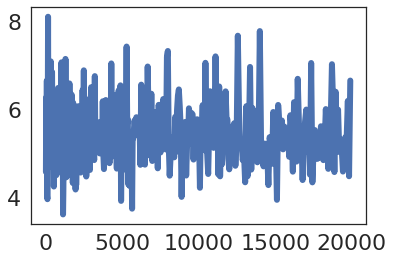

In [53]:
plt.plot(result_df.groupby('m', as_index=True)['grad'].max())

<AxesSubplot:xlabel='m', ylabel='grad_running_ub'>

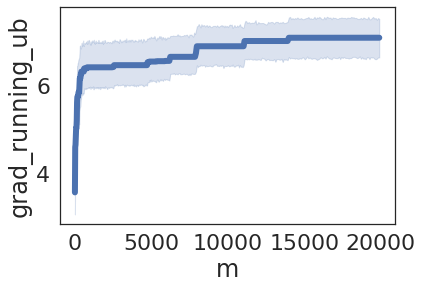

In [39]:
sns.lineplot(x='m', y='grad_running_ub', data=result_df)


## Main result exp1 MNIST

In [7]:
root_dir = 'results/t1/'
path = 'try1_t10_r.4'
lp_ylim = (-.1,8.5)
sm_ylim = (-.1, 60)
details = get_exp_details(root_dir, path)
grad_list, hess_list, K_g, L_g, x_values, gen_err_list,K_g_run_avg, L_g_run_avg, K_g_avg, L_g_avg = get_exp_results(details)
# plot_e1(grad_list, hess_list, x_values, path='mnist_rough.pdf', lp_ylim=lp_ylim, sm_ylim=sm_ylim)

hess list shape: (8, 400)
grad list shape: (8, 400)
gen err list shape: (8, 400)


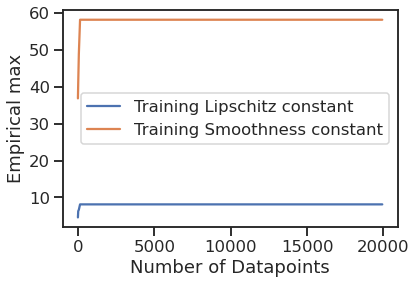

In [8]:
plot_stability_e1(grad_list, hess_list, x_values, path='mnist.pdf')

## Main result exp1 FMNIST

In [9]:
root_dir = 'results/t2/'
path = 'try2f_t8_r.4'
lp_ylim = (-0.1, 13)
sm_ylim = (-0.1, 110)
details = get_exp_details(root_dir, path)
grad_list, hess_list, K_g, L_g, x_values, gen_err_list,K_g_run_avg, L_g_run_avg, K_g_avg, L_g_avg = get_exp_results(details)
# plot_e1(grad_list, hess_list, x_values, path='Fmnist.pdf',lp_ylim= lp_ylim,sm_ylim= sm_ylim)

hess list shape: (8, 400)
grad list shape: (8, 400)
gen err list shape: (8, 400)


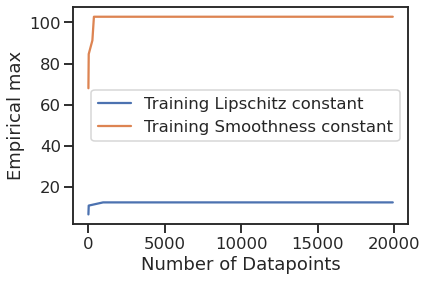

In [10]:
plot_stability_e1(grad_list, hess_list, x_values, path='Fmnist.pdf')

In [58]:
K_g, L_g

(8.1174, 58.185)